In [13]:
import sys
sys.path.append('/pasteur2/u/yuhuiz/CVPR/AutoConverter/VLMEvalKit')

from vlmeval import *
dataset_name = 'MMMU_DEV_VAL'
dataset = build_dataset(dataset_name)

In [27]:
from PIL import Image
import base64
import io

def base64_to_image(base64_str):
    """
    Convert a base64 string to a PIL Image.
    
    Args:
        base64_str (str): The base64 encoded image string.
        
    Returns:
        PIL.Image.Image: The image object.
    """
    # Decode the base64 string into bytes
    image_data = base64.b64decode(base64_str)
    
    # Convert bytes into a PIL image
    image = Image.open(io.BytesIO(image_data))
    
    return image

In [31]:
from pydantic import BaseModel
from openai import OpenAI
from textwrap import dedent

client = OpenAI()

class Distractor(BaseModel):
    text: str
    reason: str

class Distractors(BaseModel):
    distractors: list[Distractor]


def convert_to_multi_choice(item):
    question = item["question"]
    answer = item[item["answer"]]
    image_base64 = item["image"]

    system_prompt = "You are a helpful assistant."
    user_prompt = f"""Generate 3 distractors for this visual question:

    Question: {question}
    Answer: {answer}
    """

    completion = client.beta.chat.completions.parse(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": dedent(system_prompt)},
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": dedent(user_prompt)},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/png;base64,{image_base64}"},
                    },
                ],
            },
        ],
        response_format=Distractors,
    )

    distractors = completion.choices[0].message.parsed.dict()
    choices = [answer] + [distractor["text"] for distractor in distractors["distractors"]]
    reasons = [None] + [distractor["reason"] for distractor in distractors["distractors"]]
    multi_choice_questions = {
        "question": question,
        "choices": choices,
        "reasons": reasons,
        "answer": answer,
    }
    return multi_choice_questions

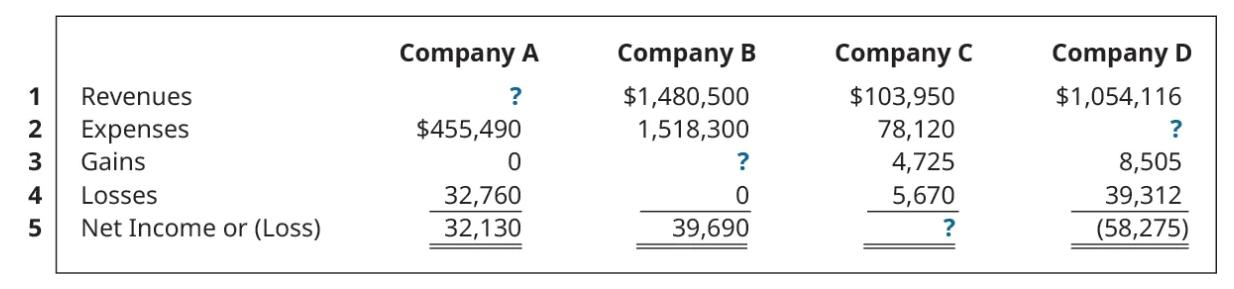

{'question': 'Each of the following situations relates to a different company. <image 1> For company B, find the missing amounts.',
 'choices': ['$77,490', '$81,710', '$107,315', '$64,920'],
 'reasons': [None,
  'This value is close to the correct answer, which might confuse someone aiming to check for mathematical accuracy without recalculating.',
  'This value is significantly higher, possibly misleading someone interpreting the values as higher numbers than they are.',
  'This value is lower and might mislead someone who is guessing or looking for smaller discrepancies.'],
 'answer': '$77,490'}

In [34]:
item = dataset[0]

multi_choice_questions = convert_to_multi_choice(item)
display(base64_to_image(item["image"]))
display(multi_choice_questions)